In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Numeric parameters

In [3]:
m = 1.
g = 10.
x0 = [1., 0.]
T = 2.
h_sim = np.linspace(0.001, 0.1, 20)
# h_sim = np.logspace(-3, -1, 20)

# Utils

In [4]:
def simulate(x_next, x0, T, h):
    x_sim = [x0]
    t_sim = [0.]
    while t_sim[-1] < T - h/2.:
        x_sim.append(x_next(x_sim[-1], h))
        t_sim.append(t_sim[-1]+h)
    return np.vstack(x_sim), np.array(t_sim)

In [5]:
def plot_trajectories(x_next):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for h in h_sim:
        x_sim, t_sim = simulate(x_next, x0, T, h)
        ax.plot(t_sim, [h]*len(t_sim), x_sim.T[0])
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$h$')
    ax.set_zlabel(r'$q$')
    plt.show()

# Model (2.11)-(2.15) from [1]

In [6]:
eps = .5

<IPython.core.display.Javascript object>


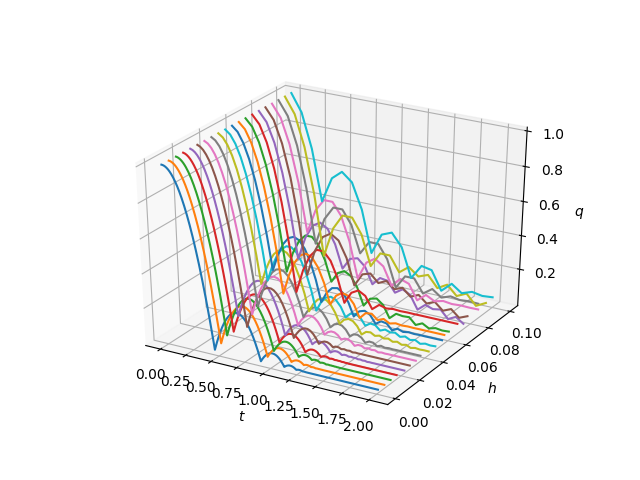

In [19]:
def x_next(x, h):
    v_next = x[1] - h*g
    q_next = x[0] + h*v_next
    if q_next < 0:
        v_next = - eps*x[1]
        q_next = x[0] + h*v_next
    return [q_next, v_next]
plot_trajectories(x_next)
# plt.savefig('bouncing_ball_1.pdf')

Remarks:

- The trajectories do not depend on the mass of the ball.
- Trajectories are discontinuous in the positioning of the impact within the time step.

## Model (2.11)-(2.15) from [1], with position-update correction 

<IPython.core.display.Javascript object>


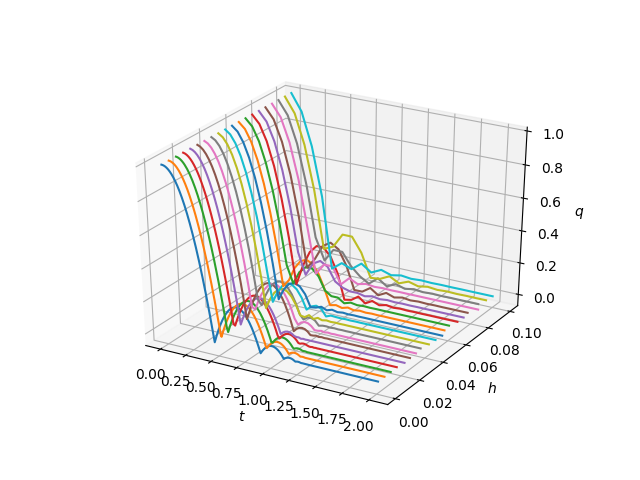

In [20]:
def x_next(x, h):
    v_next = x[1] - h*g
    q_next = x[0] + h*v_next
    if q_next < 0:
        v_next = - eps*x[1]
        q_next = - eps*x[0] - h*eps*x[1]
    return [q_next, v_next]
plot_trajectories(x_next)
plt.savefig('bouncing_ball_2.pdf')

<IPython.core.display.Javascript object>


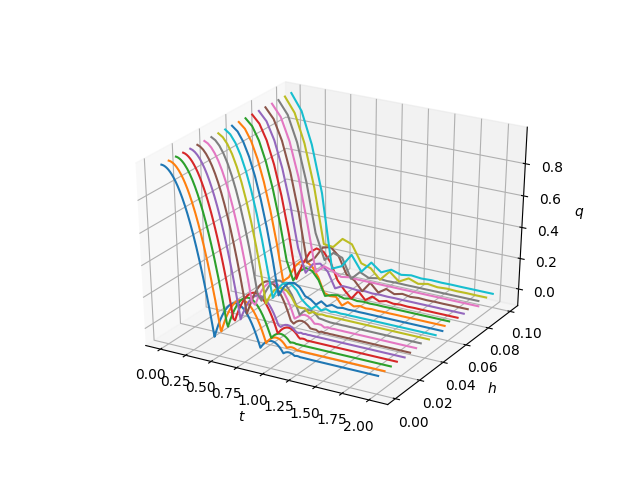

In [15]:
def x_next(x, h):
    v_next = x[1] - h*g
    q_next = x[0] + h*v_next
    if q_next < 0:
        v_next = - eps*x[1] + .5*h*g*(eps-1)
        q_next = - eps*x[0] - h*eps*x[1] + .25*g*h**2*(eps-2)
    return [q_next, v_next]
plot_trajectories(x_next)

<IPython.core.display.Javascript object>


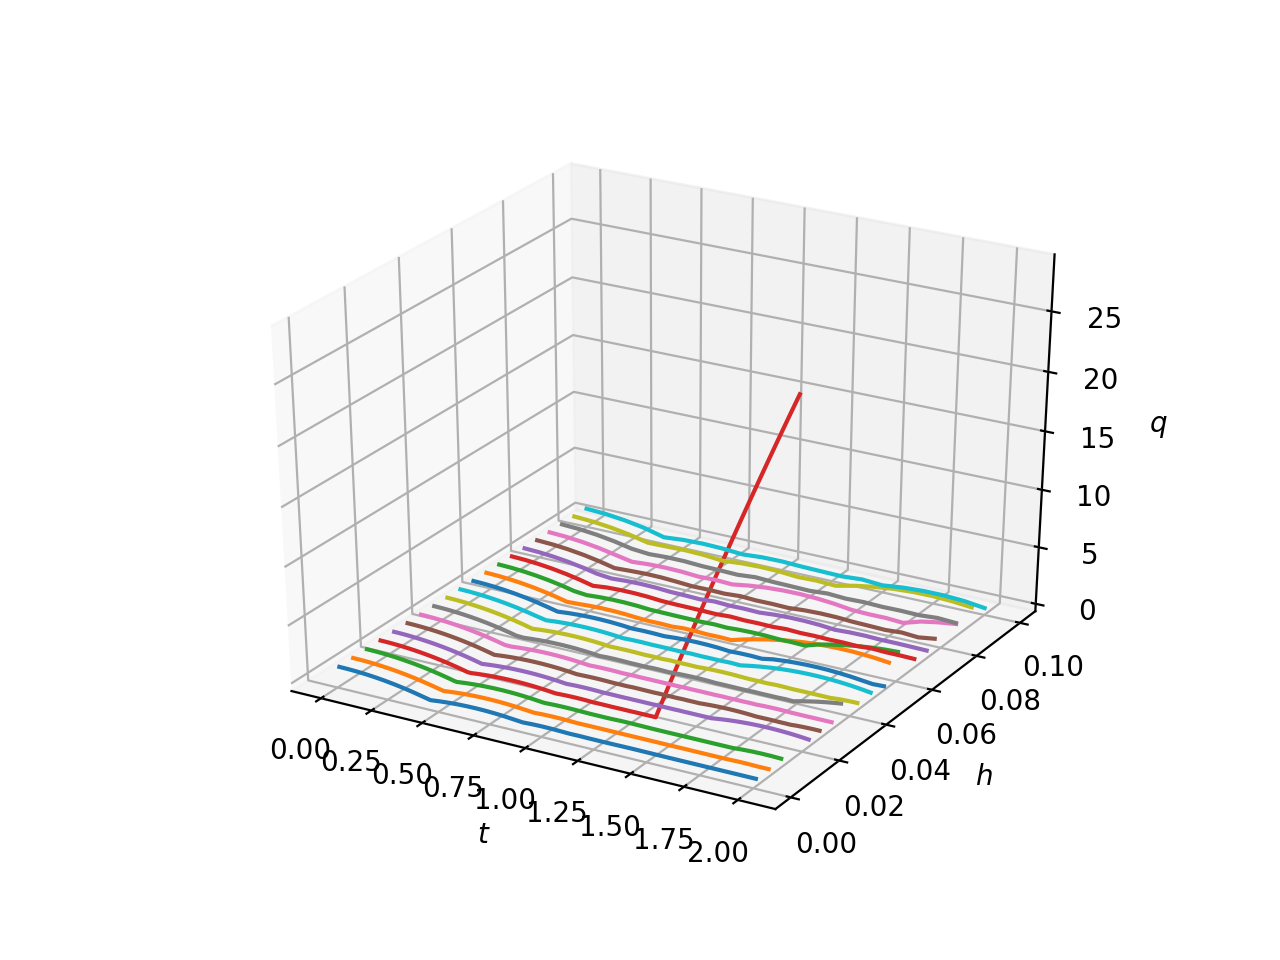

In [9]:
def x_next(x, h):
    v_next = x[1] - h*g
    q_next = x[0] + h*v_next
    if q_next < 0:
        v_next = - eps*x[1] - eps*g*x[0]/x[1] - g*(h + x[0]/x[1])
        q_next = - eps*x[0] - h*eps*x[1]
    return [q_next, v_next]
plot_trajectories(x_next)

# Linear spring-damper model, explicit Euler

In [10]:
k = 1000.
c = 15.

<IPython.core.display.Javascript object>


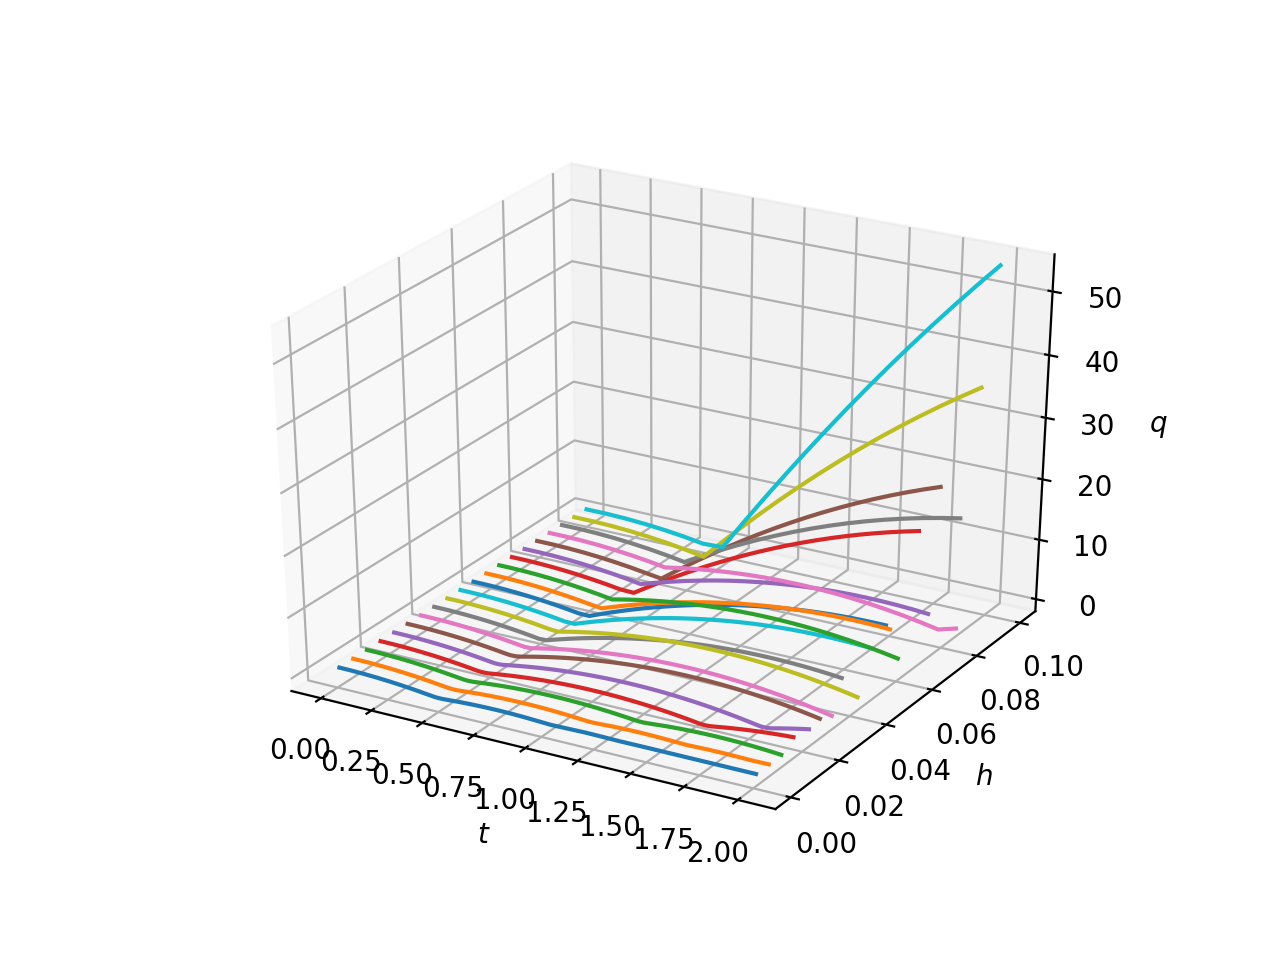

In [11]:
def x_next(x, h):
    f = - k*x[0] - c*x[1]
    v_next = x[1] - h*g if (x[0] + h*x[1] >= 0 or f <= 0.) else x[1] + h*(f/m - g)
    q_next = x[0] + h*x[1]
    return [q_next, v_next]
plot_trajectories(x_next)

## Linear spring-damper model, semi-implicit Euler

<IPython.core.display.Javascript object>


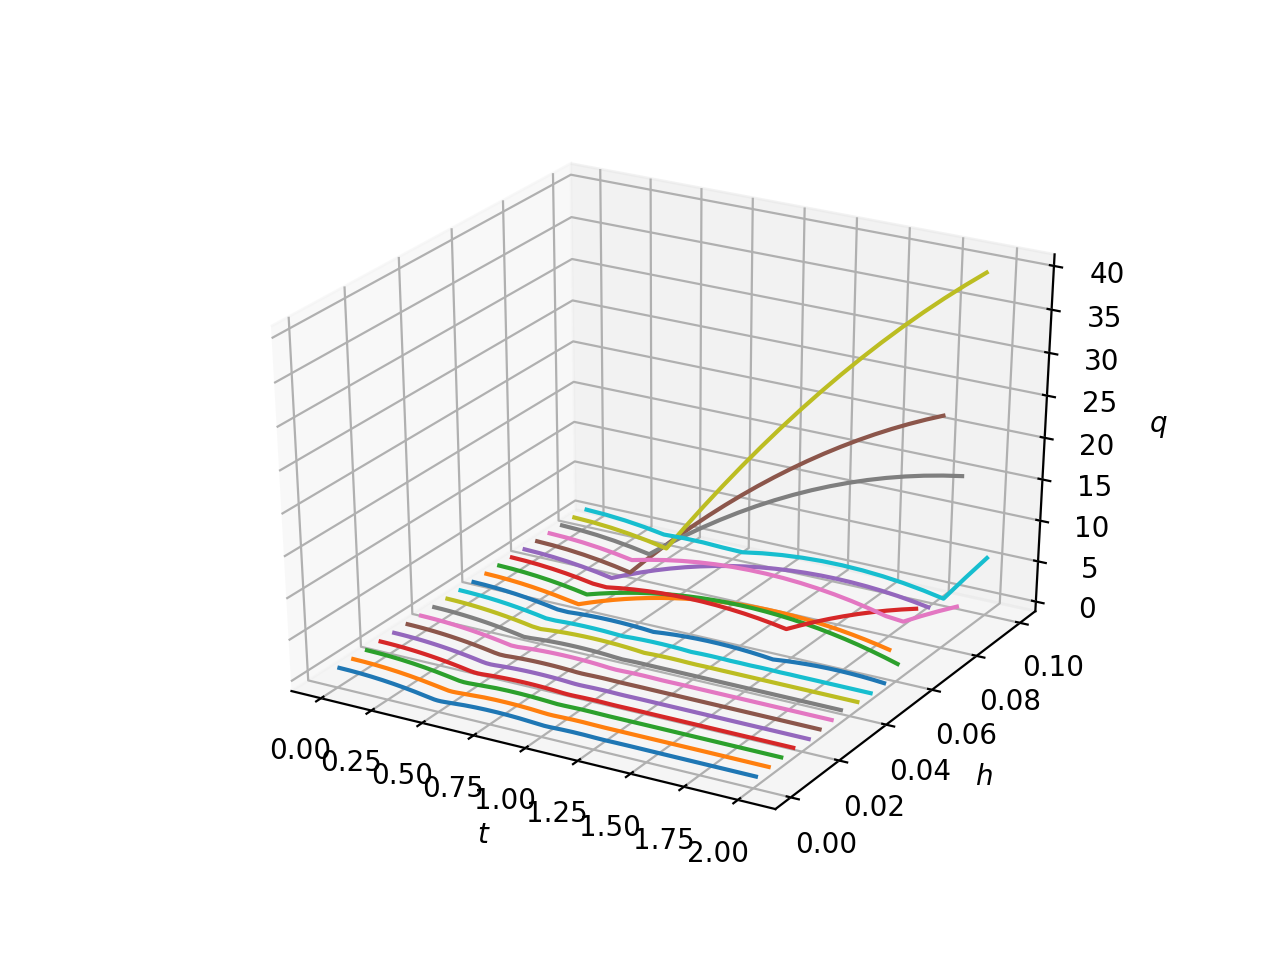

In [12]:
def x_next(x, h):
    f = - k*x[0] - c*x[1]
    v_next = x[1] - h*g if (x[0] + h*x[1] >= 0 or f <= 0.) else x[1] + h*(f/m - g)
    q_next = x[0] + h*v_next
    return [q_next, v_next]
plot_trajectories(x_next)

## Linear spring-damper model, implicit Euler

In [15]:
A1 = np.array([[0, 1],[0, 0]])
b1 = np.array([0, -g])
A2 = np.array([[0, 1],[-k/m, -c/m]])
b2 = b1

<IPython.core.display.Javascript object>


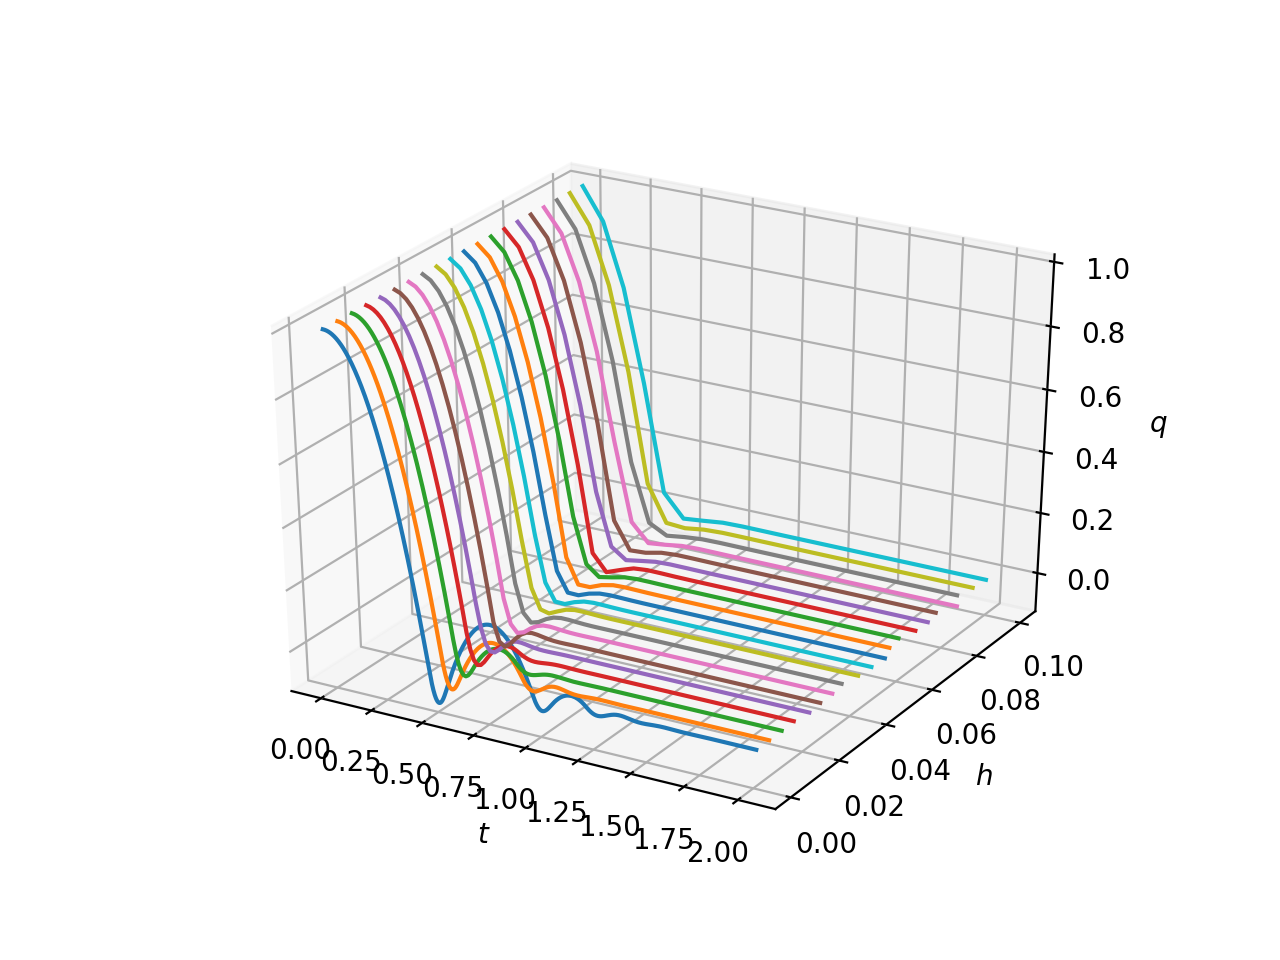

In [16]:
def x_next(x, h):
    x_next_1 = np.linalg.inv(np.eye(2)-h*A1).dot(x+h*b1)
    x_next_2 = np.linalg.inv(np.eye(2)-h*A2).dot(x+h*b2)
    f = - k*x_next_2[0] - c*x_next_2[1]
    if x_next_1[0] >= 0. or f < 0.:
        return x_next_1
    return x_next_2
plot_trajectories(x_next)

# Linear spring-damper model, explicit Runge-Kutta 4th

<IPython.core.display.Javascript object>


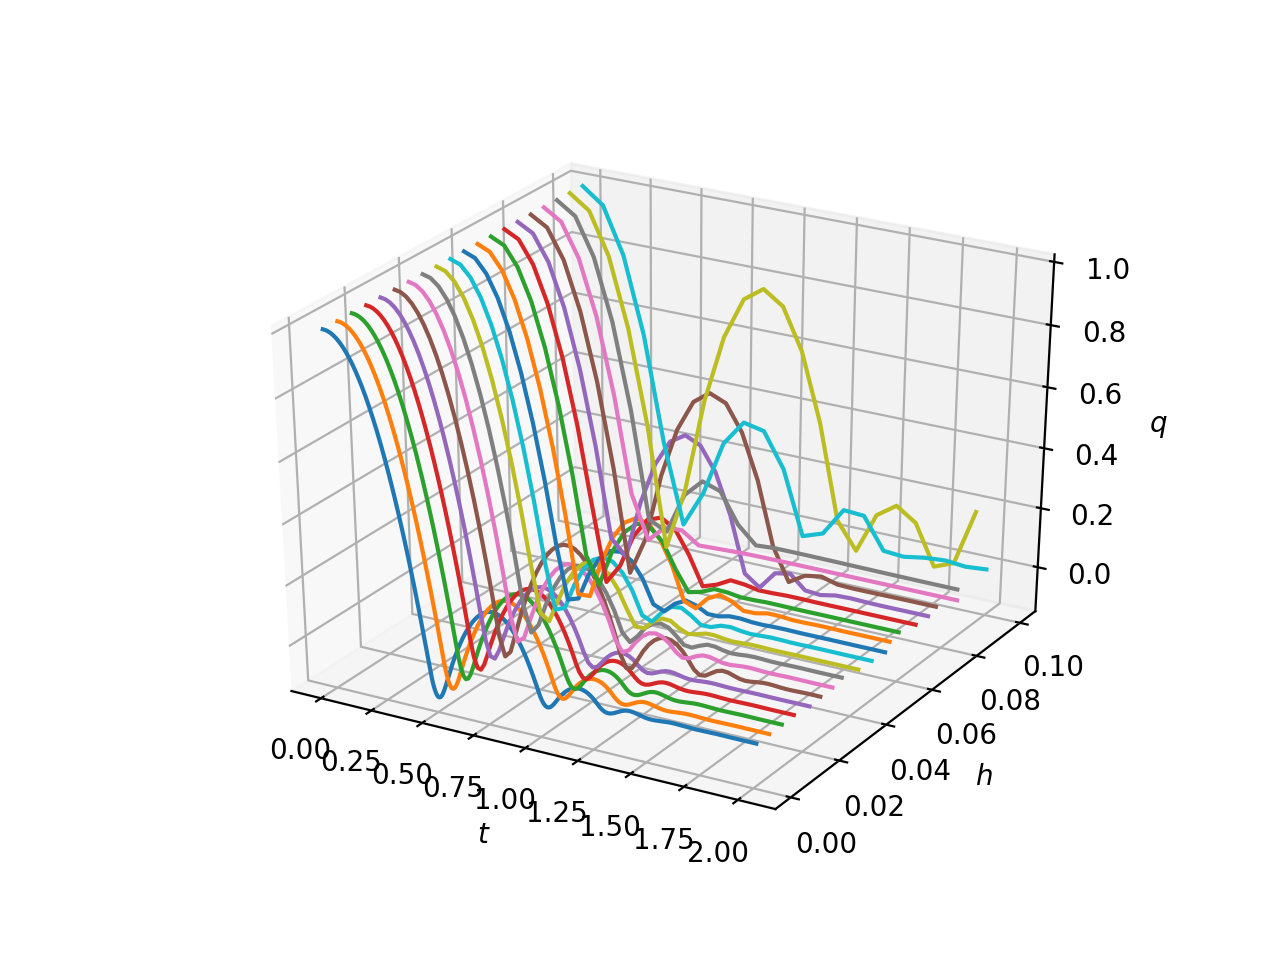

In [17]:
def x_dot(x):
    f = - k*x[0] - c*x[1]
    if x[0] >= 0. or f < 0.:
        return np.array([x[1], -g])
    else:
        return np.array([x[1], - g - k*x[0]/m - c*x[1]/m])
def x_next(x, h):
    k1 = h*x_dot(x)
    k2 = h*x_dot(x + k1/2.)
    k3 = h*x_dot(x + k2/2.)
    k4 = h*x_dot(x + k3)
    return x + (k1 + 2.*k2 + 2.*k3 + k4)/6.
plot_trajectories(x_next)

In [14]:
def x_next(x, h):
    k1 = h*x_dot(x)
    k2 = h*x_dot(x + k1/2.)
    k3 = h*x_dot(x + k2/2.)
    k4 = h*x_dot(x + k3)
    return x + (k1 + 2.*k2 + 2.*k3 + k4)/6.

## References
[1] D. E. Stewart - Rigid-Body Dynamics with Friction and Impact